## Transformer for rhythm reconstruction

- Reference Code: https://juejin.im/post/5b9f1af0e51d450e425eb32d
- Also referred to Hungyi-Lee's HW8 structure: https://colab.research.google.com/drive/11iwJbQv9iScRo6kGP7YfyHaaorlHhzMT

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms
import gensim

import numpy as np
import random
import json
import pickle

import matplotlib as plt
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from matplotlib.font_manager import *  
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
#font = FontProperties(fname='./SimHei.ttf')

import sys
import os
sys.path.append("..")
sys.path.append("/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed")
sys.path.append("/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_loader")
from data_loader.Nottingham_database_preprocessor import *
from data_loader.Nottingham_database_preprocessor_util import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
%matplotlib inline

cpu


### Overall configurations

In [218]:
class configurations(object):
    def __init__(self):
        self.batch_size = 1
        self.emb_dim = 256
        self.hid_dim = 512
        self.n_layers = 6
        self.num_heads = 8
        self.dropout = 0.5
        self.ffn_dim = 2048
        self.learning_rate = 0.0001
        self.max_output_len = 800
        self.num_steps = 12000
        self.store_steps = 4000
        self.summary_steps = 1000
        self.mask_prob = 0.8
        self.head_len = 10
        self.sampling = True
        self.load_model = False
        self.store_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_transformer/model_folder/init_handcrafted"
        self.load_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_transformer/model_folder/init_handcrafted/model_"+str(self.num_steps)
        self.data_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_folder/"

config = configurations()
embedding_tensor = None

### Dataset and preprocessing

- Dictionary controllers: {$1:'<PAD>',2:'<BOS>',3:'<EOS>',4:'<UNK>',5:'<MASK>',6:'<CLS>'$}, position_bias=20

In [4]:
class LabelTransform(object):
    def __init__(self, size, pad):
        self.size = size
        self.pad = pad

    def __call__(self, label):
        label = np.pad(label, (0, (self.size - label.shape[0])), mode='constant', constant_values=self.pad)
        return label
        
def jsonKeys2int(x):
    if isinstance(x, dict):
        return {int(k):v for k,v in x.items()}
    return x

class RhythmDataset(data.Dataset):
    def __init__(self, root, max_output_len, set_name, pad=False, mask_prob = 0, head_len = 10):
        self.root = root
        self.max_output_len = max_output_len
        self.word2int, self.int2word = self.get_dictionary()
        self.data = []
        with open(os.path.join(self.root, f'{set_name}'), "rb") as f:
            self.data=pickle.load(f)
            print (f'{set_name} dataset size: {len(self.data)}')

        self.max_id = max(self.int2word)
        print('max index in dict is ',self.max_id)
        self.vocab_size = self.max_id+1
        self.dict_size = len(self.word2int)
        self.pad = pad
        self.mask_prob = mask_prob
        self.generate_mode = False
        self.bias_tokens_n = 20
        self.head_len = head_len
        self.transform = LabelTransform(max_output_len, self.word2int['<PAD>'])

    def get_dictionary(self):
        with open(os.path.join(self.root+'/rhythm_dict', f'vocab_word2int.json'), "r") as f:
            word2int = json.load(f)
        with open(os.path.join(self.root+'/rhythm_dict', f'vocab_int2word.json'), "r") as f:
            int2word = json.load(f, object_hook=jsonKeys2int)
        return word2int, int2word

    def __len__(self):
        return len(self.data)

    def __getitem__(self, Index):
        global device
        sentence = self.data[Index]
        sentence_idx = []
        target = []
        for index,word in enumerate(sentence):
            word_sen = word
            if self.mask_prob>0 and index>self.head_len:
                if random.random()<self.mask_prob:
                    temp_rand = random.random()
                    if temp_rand<1:
                        word_sen = '<MASK>'
                    elif temp_rand>=1:
                        word_sen_id = int((self.max_id-self.bias_tokens_n)*random.random())+self.bias_tokens_n
                        word_sen = self.int2word[word_sen_id]
            if self.generate_mode and index>self.head_len:
                word_sen = '<MASK>'
            if (word_sen in self.word2int.keys()):        
                sentence_idx.append(self.word2int[word_sen])
            else:
                sentence_idx.append(self.word2int['<UNK>'])
            if (word in self.word2int.keys()):
                target.append(self.word2int[word])
            else:
                target.append(self.word2int['<UNK>'])

        if self.pad:
            sentence_idx = np.asarray(sentence_idx)
            sentence_idx = self.transform(sentence_idx)
            target = np.asarray(sentence_idx)
            target = self.transform(sentence_idx)

        sentence_idx = torch.LongTensor(sentence_idx).to(device)
        target = torch.LongTensor(target).to(device)
        return sentence_idx, target

In [5]:
rhythm_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data',
                              pad=False, mask_prob = config.mask_prob, head_len = config.head_len)
mask_index = rhythm_dataset.word2int['<MASK>']
total_vocab_size = rhythm_dataset.vocab_size
print('Total vocab size is ',total_vocab_size)

rhythm_pattern_list_all.data dataset size: 1019
max index in dict is  470
Total vocab size is  471


### Gensim word embedding training

#### gensim w2v training

In [6]:
import gensim
emb_dim = config.emb_dim
gensim_pretrain_model = gensim.models.Word2Vec(rhythm_dataset.data, size=emb_dim, window=3, min_count=1, workers=4)
rootpath = config.data_path
gensim_pretrain_model.save(os.path.join(rootpath, 'rhythm_pattern_wv.model'))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### Trying similarity

In [ ]:
gensim_pretrain_model.wv.most_similar('|4/4')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('R3.000,N1.000|4/4', 0.9888843894004822),
 ('R3.000,N0.500,N0.500|4/4', 0.9777262210845947),
 ('N0.500,N0.500,N1.000,N1.000,N0.500,N0.500|4/4', 0.943331241607666),
 ('N1.000,N2.000,R1.000|4/4', 0.9430462718009949),
 ('N1.000,N0.500,N0.500,N1.000,N0.500,N0.500|4/4', 0.9412022233009338),
 ('N1.000,N1.000,N0.500,N0.500,N0.500,N0.500|4/4', 0.9403320550918579),
 ('N1.000,N0.333,N0.333,N0.333,N1.000,N1.000|4/4', 0.9402482509613037),
 ('R3.000,N0.333,N0.333,N0.333|4/4', 0.9397573471069336),
 ('N0.500,N0.500,N0.500,N0.500,N2.000|4/4', 0.9385297298431396),
 ('N1.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4', 0.9377706050872803)]

In [ ]:
gensim_pretrain_model.wv.most_similar('|6/8')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('R2.500,N0.250,N0.250|6/8', 0.9972035884857178),
 ('R2.000,N0.500,N0.500|6/8', 0.9921000003814697),
 ('R2.500,N0.500|6/8', 0.9903626441955566),
 ('N1.500,N1.000,N0.250,N0.250|6/8', 0.9854445457458496),
 ('N0.500,N0.500,N0.500,N1.000,N0.500|6/8', 0.9806761741638184),
 ('N0.500,N0.500,N0.500,N1.500|6/8', 0.9775751829147339),
 ('N1.500,N0.500,N0.500,N0.500|6/8', 0.9721093773841858),
 ('N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 0.9663959741592407),
 ('N1.000,N0.500,N1.000,N0.250,N0.250|6/8', 0.9658091068267822),
 ('N0.500,N0.500,N0.500,N0.500,N0.500,N0.250,N0.250|6/8', 0.9656189680099487)]

In [ ]:
gensim_pretrain_model.wv.most_similar('|3/4')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('N1.000,N0.500,N0.500,N1.000|3/4', 0.997168242931366),
 ('R2.000,N1.000|3/4', 0.9955852627754211),
 ('N0.500,N0.500,N1.000,N0.500,N0.500|3/4', 0.9952415227890015),
 ('N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|3/4', 0.9940783977508545),
 ('R2.000,N0.500,N0.500|3/4', 0.9929724335670471),
 ('N0.500,N0.500,N2.000|3/4', 0.9855736494064331),
 ('N0.500,N0.500,N1.000,N1.000|3/4', 0.983864963054657),
 ('R1.000,N1.000,N1.000|3/4', 0.9830150604248047),
 ('N0.500,N1.500,N1.000|3/4', 0.9757553935050964),
 ('N0.500,N0.500,N0.500,N0.500,N1.000|3/4', 0.9719539284706116)]

In [ ]:
gensim_pretrain_model.wv.most_similar('|2/4')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('N0.500,N1.000,N0.500|2/4', 0.9966467022895813),
 ('N0.250,N0.250,N0.250,N0.250,N0.750,N0.250|2/4', 0.9965900778770447),
 ('N0.250,N0.250,N0.500,N0.500,N0.500|2/4', 0.9961199760437012),
 ('R1.500,N0.500|2/4', 0.9956728219985962),
 ('N0.250,N0.500,N0.250,N0.500,N0.500|2/4', 0.9956004619598389),
 ('N0.500,N0.250,N0.250,N0.500,N0.250,N0.250|2/4', 0.9949535727500916),
 ('N1.000,N0.250,N0.250,N0.250,N0.250|2/4', 0.9949485659599304),
 ('R1.500,N0.250,N0.250|2/4', 0.9946794509887695),
 ('N0.500,N1.000,R0.250,N0.250|2/4', 0.9941388368606567),
 ('N0.500,N1.000,N0.167,N0.083,N0.250|2/4', 0.9937607645988464)]

In [ ]:
gensim_pretrain_model.wv.most_similar('N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('N0.500,N0.500,N0.500,N1.500|6/8', 0.9968592524528503),
 ('N0.500,N0.500,N0.500,N1.000,N0.500|6/8', 0.991283118724823),
 ('N0.500,N0.500,N0.500,N1.000,N0.167,N0.083,N0.250|6/8', 0.990732729434967),
 ('N0.500,N0.500,N0.500,N1.000,N0.250,N0.250|6/8', 0.9838638305664062),
 ('R2.500,N0.500|6/8', 0.9828206896781921),
 ('R2.500,N0.250,N0.250|6/8', 0.9798992872238159),
 ('N1.500,N1.000,N0.250,N0.250|6/8', 0.9760615825653076),
 ('|6/8', 0.9663959741592407),
 ('N0.250,N0.750,N0.500,N0.500,N0.500,N0.500|6/8', 0.9617275595664978),
 ('R2.000,N0.500,N0.500|6/8', 0.9584828019142151)]

In [ ]:
gensim_pretrain_model.wv.most_similar('N1.000,N1.000,N1.000,N1.000|4/4')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('N1.000,N1.000,N1.500,N0.500|4/4', 0.9972903728485107),
 ('N3.000,N0.500,N0.500|4/4', 0.9878048300743103),
 ('N1.000,N1.000,N2.000|4/4', 0.98675936460495),
 ('N1.000,N1.000,N0.500,N0.500,N1.000|4/4', 0.9858949184417725),
 ('N0.500,N0.500,N1.000,N1.000,N1.000|4/4', 0.9844369292259216),
 ('N2.000,N1.000,N0.500,N0.500|4/4', 0.9797550439834595),
 ('N1.500,N0.500,N1.000,N1.000|4/4', 0.973140299320221),
 ('N0.500,N1.000,N0.500,N1.000,N1.000|4/4', 0.9695581793785095),
 ('N3.000,N1.000|4/4', 0.9661427736282349),
 ('N1.000,N0.500,N0.500,N1.000,N1.000|4/4', 0.9641884565353394)]

In [ ]:
gensim_pretrain_model.wv.most_similar('N1.000,N1.000,N1.000,N1.000,N1.000|5/4')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('N1.000,N0.500,N0.500,N0.500,N0.500,N1.000,N1.000,N1.000|3/2',
  0.9997342228889465),
 ('N1.000,N1.000,N1.500,N0.500|2/2', 0.9996944069862366),
 ('N1.000,N1.000,N1.000,N0.500,N0.500|2/2', 0.9995219111442566),
 ('H1.000,R2.000,R1.000|4/4', 0.9995012283325195),
 ('N1.000,N1.000,N0.500,N0.500,N0.500,N0.500|2/2', 0.9994754195213318),
 ('N3.000,N1.000,N1.000,N1.000|6/4', 0.9994732141494751),
 ('N3.000,N2.000,N1.500,N0.500|4/4', 0.9993903040885925),
 ('N2.000,N1.000,N0.500,N0.500,N2.000|3/2', 0.9993655681610107),
 ('N0.333,N0.333,N0.333,N1.000,N1.500,N0.500|4/4', 0.9993579387664795),
 ('|6/4', 0.9993576407432556)]

#### make embedding for torch

In [7]:
from gensim.corpora.dictionary import Dictionary
gensim_rhythm_dict = Dictionary(rhythm_dataset.data)
gensim_rhythm_dict_word2int = gensim_rhythm_dict.token2id

In [8]:
# nn.Parameter(torch.FloatTensor(...)).to(device)
embedding_tensor =torch.randn(total_vocab_size+1,emb_dim)
for word in gensim_rhythm_dict_word2int:
    index = rhythm_dataset.word2int[word]
    this_emb = gensim_pretrain_model.wv[word]
    embedding_tensor[index] = torch.tensor(this_emb)
embedding_tensor = nn.Parameter(torch.FloatTensor(embedding_tensor)).to(device)
embedding_list = []
for index in range(total_vocab_size+1):
    word_idx_tensor = torch.LongTensor([int(index)]).to(device)
    embedding = embedding_tensor[word_idx_tensor]
    embedding_list.append(embedding)

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


#### make meter class alignment

In [9]:
class_contents_int2class = {0:'controller',1:'4/4',2:'2/2',3:'3/4',4:'6/8',5:'5/4',6:'3/2',7:'2/4',8:'9/8',9:'12/8',10:'12/16',11:'6/4',12:'others'}
int2meter = {}
int2meter_int = {}
for index in range(total_vocab_size+1):
    if index not in rhythm_dataset.int2word:
        int2meter.update({index:class_contents_int2class[12]})
        int2meter_int.update({index:12})
        continue
    else:
        find_flag = 0
        for index_meter in class_contents_int2class:
            this_class = class_contents_int2class[index_meter]
            word = rhythm_dataset.int2word[index]
            if this_class in word:
                int2meter.update({index:this_class})
                int2meter_int.update({index:index_meter})
                find_flag = 1
                #print(word)
                #print(this_class)
                break
        if not find_flag:
            int2meter.update({index:class_contents_int2class[0]})
            int2meter_int.update({index:0})

temp_embed_tensor = torch.cat(embedding_list, 0)
print('Embedding matrix shape is ',temp_embed_tensor.shape)
print('Meter alignment length is ',len(int2meter_int))
embedding_list = temp_embed_tensor.tolist()
print(np.array(embedding_list).shape)
print(np.array(list(int2meter_int.values())).shape)
embedding_array = np.array(embedding_list)
class_array = np.array(list(int2meter_int.values()))

Embedding matrix shape is  torch.Size([472, 256])
Meter alignment length is  472
(472, 256)
(472,)


#### visulizing

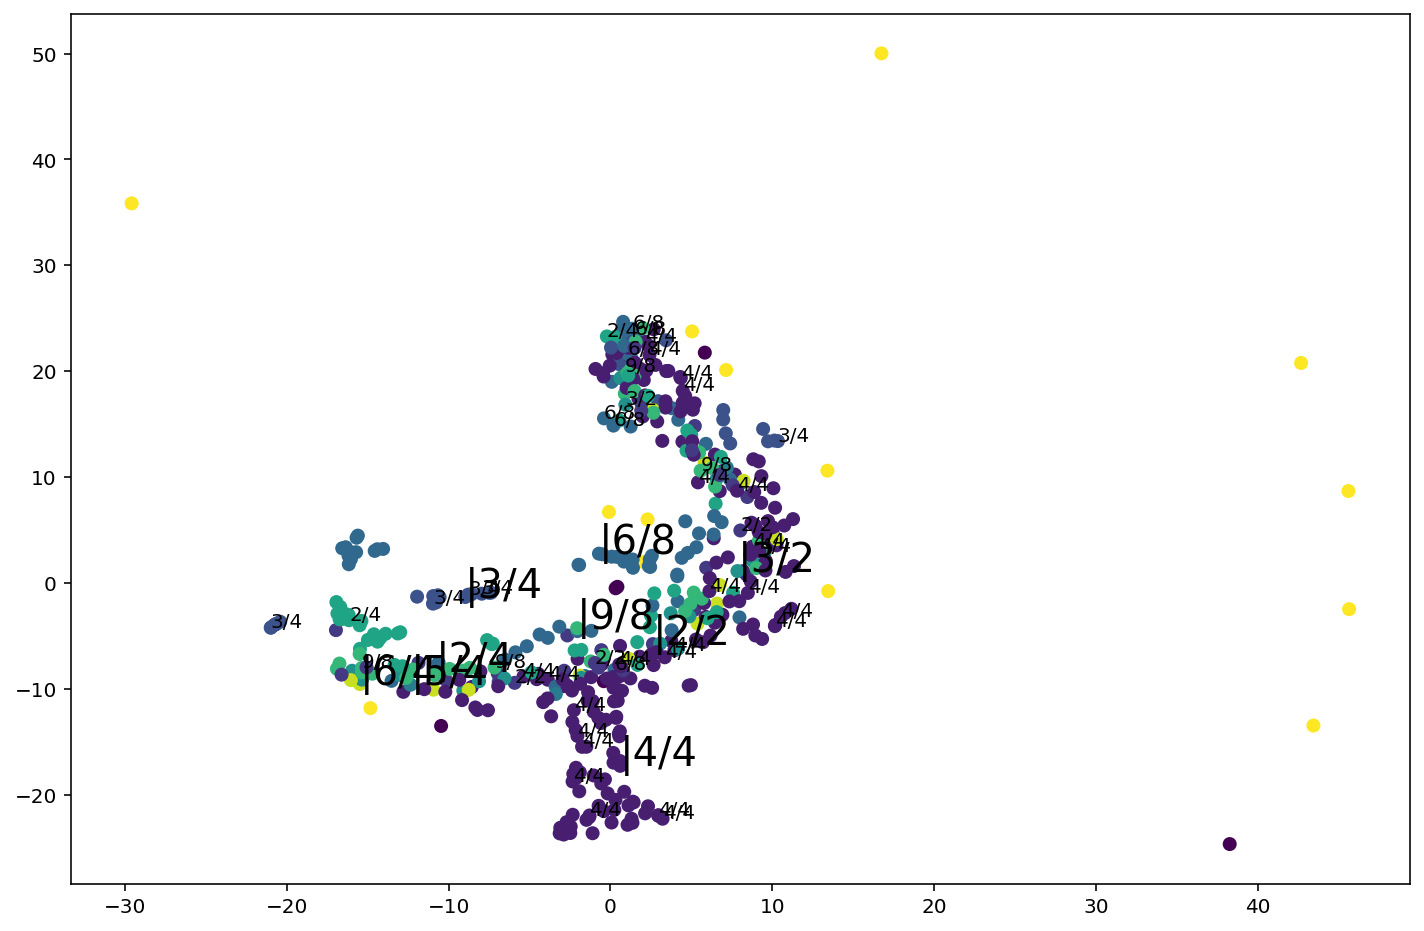

In [10]:
X_tsne = TSNE(n_components=2,learning_rate=10).fit_transform(embedding_array)

LDA = LinearDiscriminantAnalysis(n_components=2)
LDA.fit(embedding_array,class_array)
X_LDA = LDA.transform(embedding_array)

fig = plt.figure(figsize=(12,8)) 
ax = fig.gca()

ax.scatter(X_tsne[:,0],X_tsne[:,1], c=class_array)
#ax.scatter(X_LDA[:, 0], X_LDA[:, 1], c=class_array)
for i in range(len(X_tsne)):
    if i>=20: #20=bias for controller tokens in dictionary
        x=X_tsne[i][0]
        y=X_tsne[i][1]
        if i in rhythm_dataset.int2word:
            string_tmp = rhythm_dataset.int2word[i]
            meter_index = string_tmp.find('|')
            if meter_index>0:
                if i%10==0:
                    suffix = string_tmp[meter_index+1:]
                    ax.text(x , y , suffix ,size = 10)
            elif meter_index==0:
                ax.text(x , y , string_tmp ,size = 20)
plt.show()

### Transformer

#### attention layers

In [11]:
class ScaledDotProductAttention(nn.Module):
    """Scaled dot-product attention mechanism."""
    def __init__(self, attention_dropout=0.0):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(attention_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, scale=None, attn_mask=None):
        """前向传播.
        Args:
        	q: Queries [B, L_q, D_q]
        	k: Keys [B, L_k, D_k]
        	v: Values [B, L_v, D_v], L_v=L_k
        	scale: float tensor
        	attn_mask: Masking [B, L_q, L_k]
        Returns:
        	context: [B, L_q, D_v]
            attetention: [B, L_q, L_k]
        """
        # attention: [B, L_q, L_k]
        attention = torch.bmm(q, k.transpose(1, 2))
        if scale!=None:
        	attention = attention * scale
        #print("******q:",q.shape)
        #print("******k:",k.shape)
        #print("******attention:",attention.shape)
        #print("******v:",v.shape)
        if attn_mask!=None:
        	attention = attention.masked_fill_(attn_mask, -np.inf)
		# softmax
        attention = self.softmax(attention)
		# dropout
        attention = self.dropout(attention)
		# dot product with V
        # context: [B, L_q, D_v]
        context = torch.bmm(attention, v)
        return context, attention

In [12]:
class MultiHeadAttention(nn.Module):

    def __init__(self, model_dim=512, num_heads=8, dropout=0.0):
        super(MultiHeadAttention, self).__init__()

        self.dim_per_head = model_dim // num_heads
        self.num_heads = num_heads
        self.linear_k = nn.Linear(model_dim, self.dim_per_head * num_heads)
        self.linear_v = nn.Linear(model_dim, self.dim_per_head * num_heads)
        self.linear_q = nn.Linear(model_dim, self.dim_per_head * num_heads)

        self.dot_product_attention = ScaledDotProductAttention(dropout)
        self.linear_final = nn.Linear(model_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, query, key, value, attn_mask=None):
        """
        Args:
        	q: Queries [B, L_q, D_q]
        	k: Keys [B, L_k, D_k]
        	v: Values [B, L_v, D_v]
        	attn_mask: Masking [B, L_q, L_k]
        Returns:
        	output:[B, Lq, Dv]
            attention: [B*h, Lq, Lk]
        """
        residual = query

        dim_per_head = self.dim_per_head
        num_heads = self.num_heads
        batch_size = key.size(0)

        # linear projection
        key = self.linear_k(key)
        value = self.linear_v(value)
        query = self.linear_q(query)

        # split by heads
        # shape = [B*h, L_k/v/q, D/h]
        key = key.view(batch_size * num_heads, -1, dim_per_head)
        value = value.view(batch_size * num_heads, -1, dim_per_head)
        query = query.view(batch_size * num_heads, -1, dim_per_head)

        if attn_mask!=None:
            attn_mask = attn_mask.repeat(num_heads, 1, 1)
        # scaled dot product attention
        scale = (key.size(-1) // num_heads) ** -0.5
        # context [B*h, Lq, Dv/h]
        # attention [B*h, Lq, Lk]
        context, attention = self.dot_product_attention(
          query, key, value, scale, attn_mask)

        # concat heads
        # context [B, Lq, Dv]
        context = context.view(batch_size, -1, dim_per_head * num_heads)

        # final linear projection
        output = self.linear_final(context)

        # dropout
        output = self.dropout(output)

        # add residual and norm layer
        output = self.layer_norm(residual + output)

        return output, attention


In [13]:
def residual(sublayer_fn,x):
	return sublayer_fn(x)+x

#### Masking

In [14]:
def padding_mask(seq_k, seq_q):
	# seq_k or seq_q: [B,Lk] or [B,Lq]
    len_q = seq_q.size(1)
    # `auto_PAD` is 0
    pad_mask = seq_k.eq(0)
    pad_mask = pad_mask.unsqueeze(1).expand(-1, len_q, -1).to(device)  # shape [B, L_q, L_k]
    return pad_mask

def sequence_mask(seq):
    batch_size, seq_len = seq.size()
    mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.uint8),
                    diagonal=1).to(device)
    mask = mask.unsqueeze(0).expand(batch_size, -1, -1)  # [B, L, L]
    return mask

torch.Size([1, 2, 5])
tensor([[[True, True, True, True, True],
         [True, True, True, True, True]]], device='cuda:0')
tensor([[[0, 1, 1, 1, 1],
         [0, 0, 1, 1, 1],
         [0, 0, 0, 1, 1],
         [0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0]]], device='cuda:0', dtype=torch.uint8)
tensor([[[-0.6076,    -inf,    -inf,    -inf,    -inf],
         [ 0.9207,  1.0369,    -inf,    -inf,    -inf],
         [ 1.4660,  0.7191, -0.3510,    -inf,    -inf],
         [ 0.3850,  0.6859, -1.3780, -1.0459,    -inf],
         [ 0.2737,  0.9393, -0.4443, -0.8270, -0.2275]]])


/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


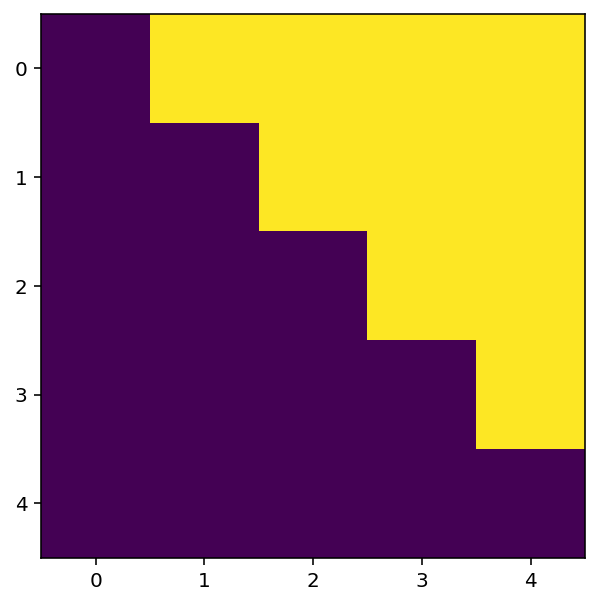

In [100]:
dk=5
dq=2
kk=torch.zeros([1,dk])
qq=torch.randn([1,dq])
att=torch.randn([1,dk,dk])

pp=padding_mask(kk, qq)
print(pp.shape)
print(pp)
ss=sequence_mask(kk)
print(ss)
plt.figure(figsize=(5,5))
plt.imshow(ss[0,:].cpu().numpy())
print(att.masked_fill_(ss.cpu(), -np.inf))

#### positional encoding

In [15]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, max_seq_len):
        """初始化。
        Args:
            d_model: 一个标量。模型的维度，论文默认是512
            max_seq_len: 一个标量。文本序列的最大长度
        """
        global device
        super(PositionalEncoding, self).__init__()
        # PE matrix
        position_encoding = torch.FloatTensor([
          [pos / pow(10000, 2.0 * (j // 2) / d_model) for j in range(d_model)]
          for pos in range(max_seq_len)]).to(device)
        # sin for even，cos for odd
        position_encoding[:, 0::2] = torch.sin(position_encoding[:, 0::2])
        position_encoding[:, 1::2] = torch.cos(position_encoding[:, 1::2])

        # first line of PE: `auto_PAD` positional encoding，
        pad_row = torch.zeros([1, d_model]).to(device)
        position_encoding = torch.cat((pad_row, position_encoding))
        
        # embedding，+1 for `auto_PAD`，
        self.position_encoding = nn.Embedding(max_seq_len + 1, d_model)
        self.position_encoding.weight = nn.Parameter(position_encoding,
                                                     requires_grad=False).to(device)
    def forward(self, input_len):
        """
        Args:
          input_len: [B, 1]; contents: L
        Returns:
          [B, L, D]
        """
        max_len = torch.max(input_len)
        # range from 1: avoid PAD(0)
        input_pos = torch.LongTensor(
          [list(range(1, len + 1)) + [0] * (max_len - len) for len in input_len]).to(device)
        return self.position_encoding(input_pos)


#### feedforward

In [16]:
class PositionalWiseFeedForward(nn.Module):

    def __init__(self, model_dim=512, ffn_dim=2048, dropout=0.0):
        super(PositionalWiseFeedForward, self).__init__()
        self.w1 = nn.Conv1d(model_dim, ffn_dim, 1)
        self.w2 = nn.Conv1d(ffn_dim, model_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, x):
        #x: [B, L, D]
        #output: [B, D, L]
        output = x.transpose(1, 2)
        #output: [B, D, L]->[B, ffn_dim, L]->[B, D, L]
        output = self.w2(F.relu(self.w1(output)))
        #output: [B, L, D]
        output = self.dropout(output.transpose(1, 2))

        # add residual and norm layer
        output = self.layer_norm(x + output)
        return output

#### encoder

In [17]:
class EncoderLayer(nn.Module):
    """Encoder的一层。"""
    def __init__(self, model_dim=512, num_heads=8, ffn_dim=2018, dropout=0.0):
        super(EncoderLayer, self).__init__()

        self.attention = MultiHeadAttention(model_dim, num_heads, dropout)
        self.feed_forward = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)

    def forward(self, inputs, attn_mask=None):

        # self attention
        # context: [B, Le, De]
        # attention: [B*h, Le, Le]
        context, attention = self.attention(inputs, inputs, inputs, attn_mask)
        
        # feed forward network
        output = self.feed_forward(context)

        return output, attention


class Encoder(nn.Module):
    """多层EncoderLayer组成Encoder。"""

    def __init__(self,
               vocab_size,
               max_seq_len,
               num_layers=6,
               model_dim=256,
               num_heads=8,
               ffn_dim=2048,
               dropout=0.0,
               embedding_init=None):
        super(Encoder, self).__init__()

        self.encoder_layers = nn.ModuleList(
          [EncoderLayer(model_dim, num_heads, ffn_dim, dropout) for _ in
           range(num_layers)])

        self.seq_embedding = nn.Embedding(vocab_size + 1, model_dim, padding_idx=0)
        if embedding_init != None:
            self.seq_embedding.weight = torch.nn.Parameter(embedding_init)
        self.pos_embedding = PositionalEncoding(model_dim, max_seq_len)

    def forward(self, inputs, inputs_len):
        # inputs: [B,Le]
        # output: [B,Le,De]
        output = self.seq_embedding(inputs)
        output += self.pos_embedding(inputs_len)
        # self_attention_mask: [B,Le,Le]
        self_attention_mask = padding_mask(inputs, inputs)

        attentions = []
        for encoder in self.encoder_layers:
            # output: [B, Le, De]
            # attention: [B*h, Le, Le]
            output, attention = encoder(output, self_attention_mask)
            attentions.append(attention)

        return output, attentions

#### decoder

In [18]:
class DecoderLayer(nn.Module):

    def __init__(self, model_dim, num_heads=8, ffn_dim=2048, dropout=0.0):
        super(DecoderLayer, self).__init__()

        self.attention = MultiHeadAttention(model_dim, num_heads, dropout)
        self.feed_forward = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)

    def forward(self,
              dec_inputs,
              enc_outputs,
              self_attn_mask=None,
              context_attn_mask=None):
        # dec_inputs: [B, Ld]
        # enc_outputs: [B, Le, De]
        # self_attn_mask: [B, Ld, Ld]
        # context_attn_mask: [B, Ld, Le]

        # self attention, all inputs are decoder inputs
        # dec_temp: [B, Ld, Dd]
        dec_temp, self_attention = self.attention(
          dec_inputs, dec_inputs, dec_inputs, self_attn_mask)

        # context attention
        # query is decoder's outputs, key and value are encoder's inputs
        # dec_output:[B, Lq, Dq]=[B, Ld, De]
        # context_attention: [B*h, Lq, Lk]=[B*h, Ld, Le]
        #print('---')
        #print('-- dec_temp:',dec_temp.shape)
        #print('-- enc_outputs:',enc_outputs.shape)
        #print('-- context_attn_mask:',context_attn_mask.shape)
        dec_output, context_attention = self.attention(
          dec_temp, enc_outputs, enc_outputs, context_attn_mask)

        # decoder's output, or context
        dec_output = self.feed_forward(dec_output)

        return dec_output, self_attention, context_attention


class Decoder(nn.Module):

    def __init__(self,
               vocab_size,
               max_seq_len,
               num_layers=6,
               model_dim=256,
               num_heads=8,
               ffn_dim=2048,
               dropout=0.0,
               embedding_init = None):
        super(Decoder, self).__init__()

        self.num_layers = num_layers

        self.decoder_layers = nn.ModuleList(
          [DecoderLayer(model_dim, num_heads, ffn_dim, dropout) for _ in
           range(num_layers)])

        self.seq_embedding = nn.Embedding(vocab_size + 1, model_dim, padding_idx=0)
        if embedding_init != None:
            self.seq_embedding.weight = torch.nn.Parameter(embedding_init)
        self.pos_embedding = PositionalEncoding(model_dim, max_seq_len)

    def forward(self, inputs, inputs_len, enc_output, context_attn_mask=None):
        # enc_output: [B, Le, De]
        # output: [B, Ld, Dd], Dd=De
        output = self.seq_embedding(inputs)
        output += self.pos_embedding(inputs_len)

        #self_attention_padding_mask: [B,Ld,Ld]
        self_attention_padding_mask = padding_mask(inputs, inputs)
        #seq_mask: [B,Ld,Ld]
        seq_mask = sequence_mask(inputs)
        #self_attn_mask: [B,Ld,Ld]
        self_attn_mask = torch.gt((self_attention_padding_mask + seq_mask), 0)

        self_attentions = []
        context_attentions = []
        for decoder in self.decoder_layers:
            # context_attn_mask: [B, Ld, Le]
            # dec_output: [B, Ld, De]
            # context_attn: [B*h, Ld, Le]
            output, self_attn, context_attn = decoder(
            output, enc_output, self_attn_mask, context_attn_mask)
            self_attentions.append(self_attn)
            context_attentions.append(context_attn)

        return output, self_attentions, context_attentions


#### transformer

In [247]:
class Transformer(nn.Module):
    def __init__(self,
               ref_vocab_size,
               ref_max_len,
               tgt_vocab_size,
               tgt_max_len,
               num_layers=6,
               model_dim=512,
               num_heads=8,
               ffn_dim=2048,
               dropout=0.2,
               sampling = True,
               embedding_init_enc = None,
               embedding_init_dec = None):
        super(Transformer, self).__init__()
        self.sampling = sampling
        self.encoder = Encoder(ref_vocab_size, ref_max_len, num_layers, model_dim,
                               num_heads, ffn_dim, dropout, embedding_init_enc)
        self.decoder = Decoder(tgt_vocab_size, tgt_max_len, num_layers, model_dim,
                               num_heads, ffn_dim, dropout, embedding_init_dec)

        self.linear = nn.Linear(model_dim, tgt_vocab_size, bias=False)
        self.softmax = nn.Softmax(dim=2)
        self.softmax_dim1 = nn.Softmax(dim=1)

    def forward(self, ref_seq, ref_len, tgt_seq, tgt_len, teach_rate = 1):
        # ref_seq: [B,Le]
        # ref_len: [B,1]
        # tgt_seq: [B,Ld]
        # tgt_len: [B,1]
        if type(tgt_len) == int:
            L = tgt_len
        else:
            L = torch.max(tgt_len)
        # context_attn_mask: [B, Ld, Le]
        context_attn_mask = padding_mask(tgt_seq, ref_seq)
        # output_enc: [B, Le, De]
        # enc_self_attn: [B, Le, Le]
        output_enc, enc_self_attn = self.encoder(ref_seq, ref_len)
        # output: [B,Ld,Dd]
        output, dec_self_attn, ctx_attn = self.decoder(
          tgt_seq, tgt_len, output_enc, context_attn_mask)
        output = self.linear(output)
        #output[0:20] -= torch.norm(output,1)/L
        # output: [B,Ld,V]
        output = self.softmax(output)

        if self.sampling:
            # pred: [B,Ld]
            pred = torch.argmax(output,dim=2)
            re_feed = pred.clone()
            for i in range(L):
                if random.random()<teach_rate:
                    re_feed[:,i]=ref_seq[:,i]

            output, dec_self_attn, ctx_attn = self.decoder(
            re_feed, tgt_len, output_enc, context_attn_mask)
            output = self.linear(output)
            # output: [B,Ld,V]
            output = self.softmax(output)

        return output, enc_self_attn, dec_self_attn, ctx_attn

    def generate_greedy(self, ref_seq, masked_seq, head_len = 10, continue_prob = 0.6):
        ref_shape = ref_seq.shape
        L = ref_shape[1]
        if L<head_len:
            L=head_len
        ref_len_tensor = torch.tensor([[L]])
        tgt_len_tensor = torch.tensor([[L]])

        # preds: [B,Ld]
        preds = masked_seq.clone()
        enc_self_attn = None
        dec_self_attn = None
        ctx_attn = None
        # context_attn_mask: [B,Ld,Le]
        step=head_len
        while step<L:
            output, enc_self_attn, dec_self_attn, ctx_attn = self.forward(ref_seq, ref_len_tensor, preds, tgt_len_tensor, teach_rate = 0)
            next_word_distribution = output[:,step]
            if step<L-1:
                next_word_distribution[0:20] = next_word_distribution[0:20]*0
            _, next_word = torch.max(next_word_distribution, dim = 1)
            preds[:,step]=next_word
            while random.random()<continue_prob:
                step += 1
                if step>=L:
                    break
                next_word_distribution = output[:,step]
                if step<L-1:
                    next_word_distribution[0:20] = next_word_distribution[0:20]*0
                # next_word: [B]
                _, next_word = torch.max(next_word_distribution, dim = 1)
                preds[:,step]=next_word
            step+=1

        return preds,enc_self_attn,dec_self_attn,ctx_attn



### Data postprocess

In [20]:
def tokens2sentence(outputs, int2word):
    sentences = []
    for tokens in outputs:
        sentence = []
        for token in tokens:
            word = int2word[int(token)]
            if word == '<EOS>':
                break
            sentence.append(word)
        sentences.append(sentence)
    
    return sentences

In [21]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def computebleu(sentences, targets):
    score = 0 
    if len(sentences) < len(targets):
        #print(sentences)
        #print(targets)
        to_add = len(targets)-len(sentences)
        for i in range(to_add):
            sentences.append('<PAD>')
    else:
        assert (len(sentences) == len(targets))


    def cut_token(sentence):
        tmp = []
        for token in sentence:
            if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
                tmp.append(token)
            else:
                tmp += [word for word in token]
        return tmp 

    for sentence, target in zip(sentences, targets):
        sentence = cut_token(sentence)
        target = cut_token(target)
        score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))                                                                                          
    
    return score

In [22]:
def infinite_iter(data_loader):
    it = iter(data_loader)
    while True:
        try:
            ret = next(it)
            yield ret
        except StopIteration:
            it = iter(data_loader)

In [23]:
def mask_sequence(ref_seq, head_seq, mask_index, head_len = 10, cut_down = False):
    global device
    ref_len = ref_seq.shape[1]
    ref_shape = ref_seq.shape
    masked_seq = (torch.LongTensor(torch.ones(ref_shape).long())*mask_index).to(device)
    for i in range(head_len):
        masked_seq[:,i] = head_seq[:,i]
    if cut_down:
        masked_seq = masked_seq[0:head_len]
    return masked_seq

In [24]:
ref_for_test = torch.tensor([[2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7]])
print(ref_for_test)
masked_for_test = mask_sequence(ref_for_test,ref_for_test,999,10,cut_down=False)
print(masked_for_test)

tensor([[2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7]])
tensor([[  2,   3,   4,   5,   6,   7,   8,   9,   0,   1, 999, 999, 999, 999,
         999, 999]])


In [25]:
def schedule_sampling(step,summary_steps):
    return 1-0.8*step/summary_steps

## model trial

### prepare training set

In [185]:
train_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data',
                              pad=False, mask_prob = config.mask_prob, head_len = config.head_len)
train_loader = data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
train_iter = infinite_iter(train_loader)
mask_index = train_dataset.word2int['<MASK>']
vocab_size = train_dataset.vocab_size
max_len = config.max_output_len

rhythm_pattern_list_all.data dataset size: 1019
max index in dict is  470


In [186]:
src_test, tgt_test = train_dataset[5]
print('source:', src_test)
print('target:', tgt_test)

source: tensor([ 2, 24, 52, 27, 53, 53, 53, 27, 53, 27, 54, 27,  5,  5, 53,  5,  5, 27,
        54,  5, 53,  5,  5, 27, 53,  5,  5,  5,  5,  5,  5,  5,  5,  5, 54,  5,
         5, 27, 53,  5,  5,  5,  5,  5,  5, 27,  5,  5, 53,  5,  5])
target: tensor([ 2, 24, 52, 27, 53, 53, 53, 27, 53, 27, 54, 27, 53, 53, 53, 27, 53, 27,
        54, 27, 53, 53, 53, 27, 53, 27, 54, 27, 53, 53, 53, 27, 53, 27, 54, 27,
        53, 27, 53, 27, 53, 27, 54, 27, 53, 27, 53, 27, 53, 27,  3])


### handcrafted embedding initialization

In [232]:
#embedding_init = embedding_tensor + nn.Parameter(torch.randn(embedding_tensor.shape).to(device))*2
init_embedding_auto = nn.Embedding(vocab_size + 1, config.emb_dim, padding_idx=0)
print(class_contents_int2class)
scale_init = 1
scale_bias = 0.5
scale_special = 5
embedding_init = init_embedding_auto.weight*scale_init
embedding_init[0:20] = embedding_init[0:20]*3
#nn.init.kaiming_uniform_(embedding_init, a=0, mode='fan_in', nonlinearity='leaky_relu')*scale
bias_list_for_emb = torch.randn(len(class_contents_int2class),config.emb_dim)*scale_bias
bias_list_for_emb[0] = bias_list_for_emb[0]*scale_special
bias_list_for_emb[-1] = bias_list_for_emb[-1]*scale_special

for i in range(vocab_size+1):
    this_class_id = int2meter_int[i]
    #print((i,this_class_id))
    embedding_init[i,:]=embedding_init[i,:]+bias_list_for_emb[this_class_id]

embedding_init = embedding_init.to(device)

{0: 'controller', 1: '4/4', 2: '2/2', 3: '3/4', 4: '6/8', 5: '5/4', 6: '3/2', 7: '2/4', 8: '9/8', 9: '12/8', 10: '12/16', 11: '6/4', 12: 'others'}


### show embedding initialization with tSNE

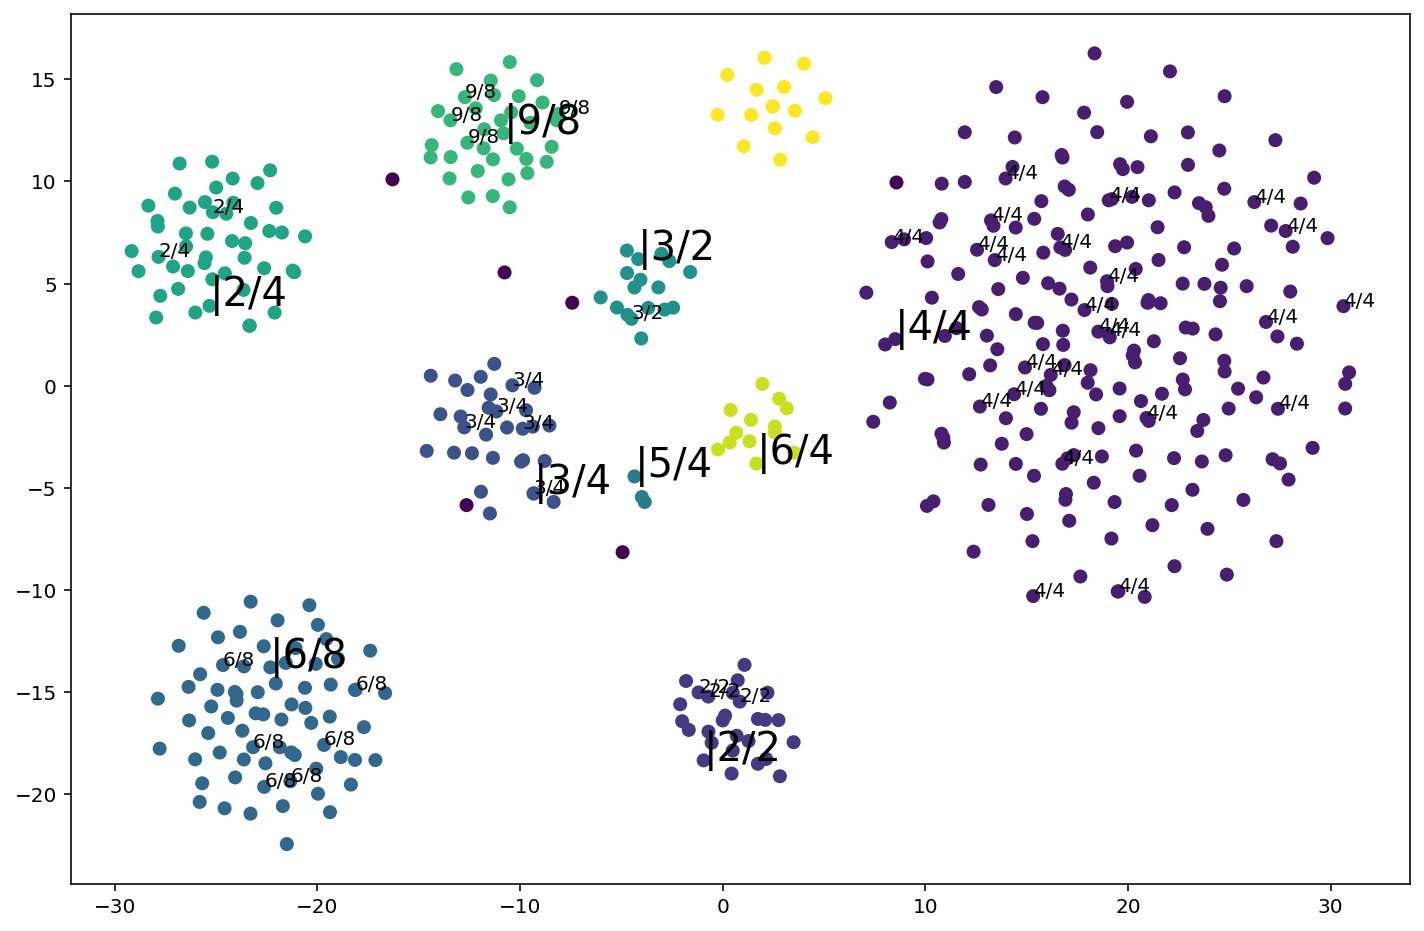

In [233]:
embedding_init_array = embedding_init.cpu().detach().numpy()
X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(embedding_init_array)
fig = plt.figure(figsize=(12, 8)) 
ax = fig.gca()

ax.scatter(X_tsne[:,0],X_tsne[:,1], c=class_array)
for i in range(len(X_tsne)):
    if i>=20: #20=bias for controller tokens in dictionary
        x=X_tsne[i][0]
        y=X_tsne[i][1]
        if i in rhythm_dataset.int2word:
            string_tmp = rhythm_dataset.int2word[i]
            meter_index = string_tmp.find('|')
            if meter_index>0:
                if i%10==0:
                    suffix = string_tmp[meter_index+1:]
                    ax.text(x , y , suffix ,size = 10)
            elif meter_index==0:
                ax.text(x , y , string_tmp ,size = 20)
plt.show()


In [241]:
transformer = Transformer(vocab_size,max_len,vocab_size,max_len,
                          num_layers=config.n_layers,model_dim=config.emb_dim,num_heads=config.num_heads,
                          ffn_dim=config.ffn_dim,dropout=config.dropout,
                          embedding_init_enc = embedding_init, embedding_init_dec = embedding_init).to(device)

In [ ]:
transformer.named_parameters()

<generator object Module.named_parameters at 0x7fe22516d2b0>

In [ ]:
transformer.parameters

In [242]:
tensor = torch.cuda.LongTensor if device=='cuda' else torch.LongTensor

sources, targets = next(train_iter)
print('source:',sources.shape)
sources = sources.to(device)
targets = targets.to(device)

seq_len = tensor([[sources.shape[1]] for _ in range(config.batch_size)])
print('seq_len:',seq_len.shape)
output, enc_self_attn, dec_self_attn, ctx_attn = transformer(targets,seq_len,sources,seq_len)
print('output:',output.shape)

masked_seq = mask_sequence(targets, targets, mask_index, head_len = config.head_len, cut_down = False)
print('masked_seq:',masked_seq.shape)
pred, enc_self_attn, dec_self_attn, ctx_attn = transformer.generate_greedy(targets,masked_seq,head_len = config.head_len)
print('generation:',pred)

source: torch.Size([1, 35])
seq_len: torch.Size([1, 1])
output: torch.Size([1, 35, 471])
masked_seq: torch.Size([1, 35])
generation: tensor([[  2,  20,  21, 101,  22,  55, 102, 101,  22,  55, 301,  42, 195, 229,
          20, 233,  40, 275, 313, 407, 436, 233, 445, 403,  69,  28, 405,  25,
         193,  69, 235,  74, 342, 207, 462]])


In [243]:
loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(transformer.parameters(), lr=config.learning_rate)

### train

In [244]:
# p_logit: [batch, L, class_num]
# q_logit: [batch, L, class_num]
def kl_categorical(p_logit, q_logit):
    p = F.softmax(p_logit, dim=-1)
    _kl = torch.sum(p * (F.log_softmax(p_logit, dim=-1)
                                  - F.log_softmax(q_logit, dim=-1)), -1)
    return torch.sum(_kl)


preds = []
losses = []
loss_sum = 0.0
transformer.train()
transformer.zero_grad()
prob_total_steps = 1000
for step in range(prob_total_steps):
    sources, targets = next(train_iter)
    sources, targets = sources.to(device), targets.to(device)
    seq_len = tensor([[sources.shape[1]] for _ in range(config.batch_size)])
    #print('sources:',sources.shape)
    #print('targets:',targets.shape)
    #print('seq_len:',seq_len.shape)
    teach_rate = schedule_sampling(step,prob_total_steps)
    output, enc_self_attn, dec_self_attn, ctx_attn = transformer(targets,seq_len,sources,seq_len,teach_rate)

    pred = torch.argmax(output,dim=2)
    preds.append(pred)
    # output = output.reshape(-1, output.size(2))
    # targets = targets.reshape(-1)
    output = output.transpose(1, 2)
    #print('output:',output.shape)
    #print('targets:',targets.shape)
    loss = loss_function(output, targets)
    #kl_inv = 1/kl_categorical(output[:,0:-2],output[:,1:-1])
    total_loss = loss#+kl_inv
    
    optimizer.zero_grad()
    total_loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1)
    optimizer.step()

    loss_sum += loss.item()
    if (step + 1) % 5 == 0:
        loss_sum = loss_sum / 5
        print ("\r", "train [{}] loss: {:.3f}, Perplexity: {:.3f}".format(step + 1, loss_sum, np.exp(loss_sum)), end=" ")
        losses.append(loss_sum)
        loss_sum = 0.0

 train [1000] loss: 5.496, Perplexity: 243.691 

### test

In [249]:
masked, targets = next(train_iter)
masked, targets = masked.to(device), targets.to(device)
seq_len = tensor([[masked.shape[1]] for _ in range(config.batch_size)])
#print('masked:',masked.shape)
#print('targets:',targets.shape)
#print('seq_len:',seq_len.shape)
output, enc_self_attn, dec_self_attn, ctx_attn = transformer(targets,seq_len,masked,seq_len,teach_rate=0)

pred = torch.argmax(output,dim=2)

only_head = mask_sequence(targets, targets, mask_index, head_len = config.head_len, cut_down = False)

print('only_head=',only_head)

generate, enc_self_attn, dec_self_attn, ctx_attn = transformer.generate_greedy(targets,only_head,head_len = config.head_len)
#generate, enc_self_attn, dec_self_attn, ctx_attn = transformer(targets,seq_len,only_head,seq_len,teach_rate=0)
#generate = torch.argmax(generate,dim=2)

print('targets=',targets)
print('masked=',masked)
print('pred=',pred)
print('generate=',generate)


only_head= tensor([[  2,  24,  30, 327,  30,  30,  30, 327,  30, 179,   5,   5,   5,   5,
           5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
           5,   5,   5,   5,   5,   5]])
targets= tensor([[  2,  24,  30, 327,  30,  30,  30, 327,  30, 179,  30, 327,  30,  30,
          30, 327,  30,  30, 121,  69,  30,  65, 121,  69,  30,  30, 121,  69,
          30,  65, 121,  69,  30,   3]])
masked= tensor([[  2,  24,  30, 327,  30,  30,  30, 327,  30, 179,  30, 327,   5,   5,
          30,   5,  30,   5, 121,   5,   5,  65, 121,  69,  30,   5, 121,   5,
          30,   5,   5,  69,  30,   3]])
pred= tensor([[ 2, 24, 30, 78, 30, 30, 30, 30, 30, 65, 30, 81,  2,  2, 30,  2, 30,  2,
         27,  2,  2, 65, 27, 69, 30,  3, 28,  2, 30,  3,  3, 69, 30,  3]])
generate= tensor([[  2,  24,  30, 327,  30,  30,  30, 327,  30, 179,   3,   3,   2,   3,
           2,   2,   2,   2,   2,   2,   2,   2,   3,   2,   2,   2,   3,   2,
           3,   2,   2,   2,   3,  70]])


### show tSNE of trained embedding

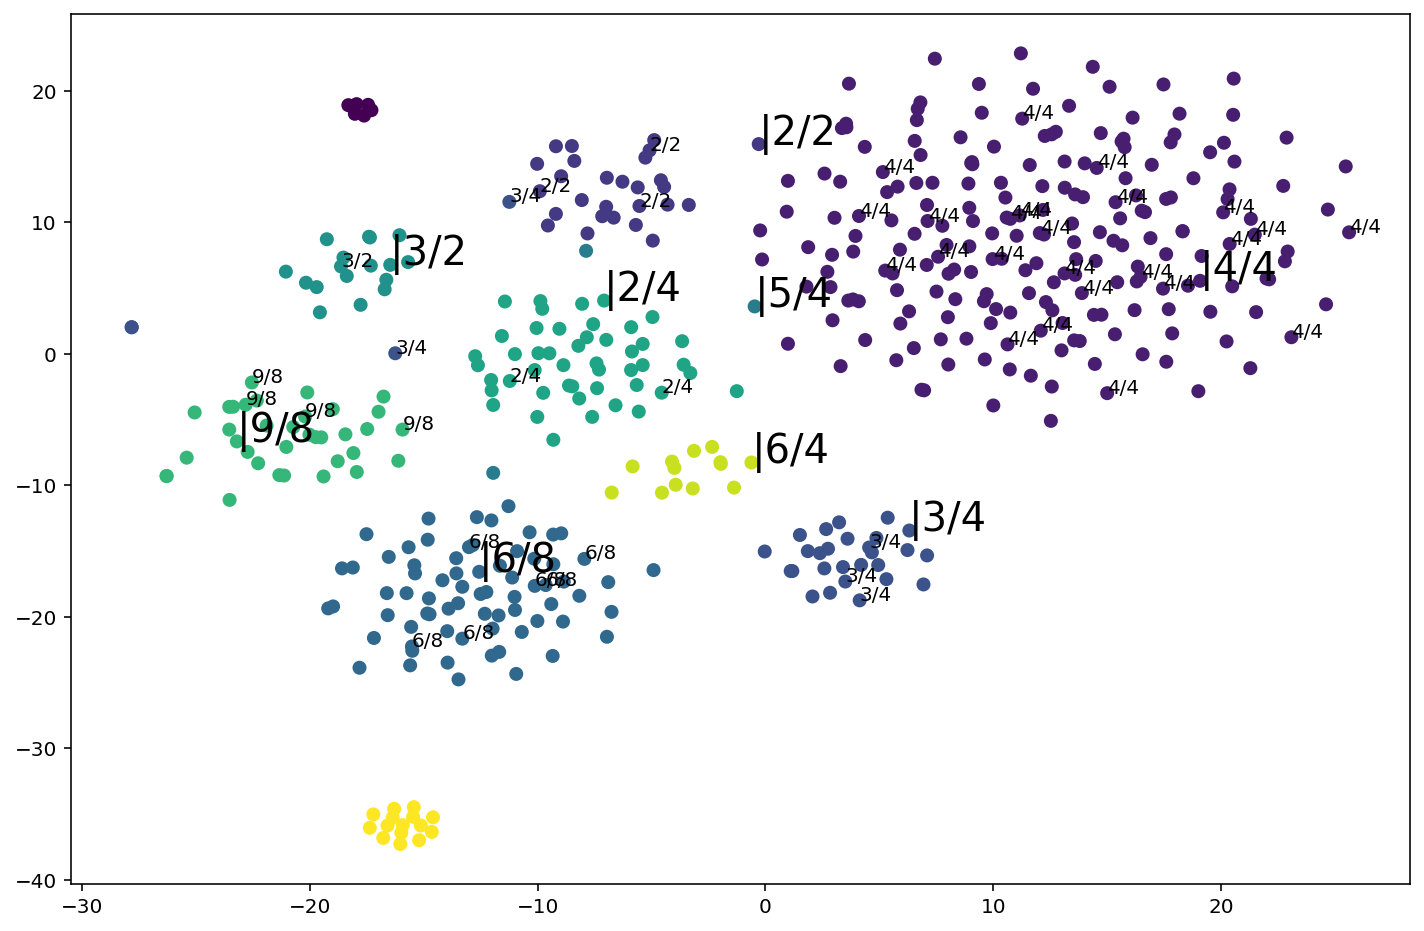

In [88]:
embedding_transformer_array = transformer.decoder.seq_embedding.weight.cpu().detach().numpy()
X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(embedding_transformer_array)
fig = plt.figure(figsize=(12, 8)) 
ax = fig.gca()

ax.scatter(X_tsne[:,0],X_tsne[:,1], c=class_array)
for i in range(len(X_tsne)):
    if i>=20: #20=bias for controller tokens in dictionary
        x=X_tsne[i][0]
        y=X_tsne[i][1]
        if i in rhythm_dataset.int2word:
            string_tmp = rhythm_dataset.int2word[i]
            meter_index = string_tmp.find('|')
            if meter_index>0:
                if i%10==0:
                    suffix = string_tmp[meter_index+1:]
                    ax.text(x , y , suffix ,size = 10)
            elif meter_index==0:
                ax.text(x , y , string_tmp ,size = 20)
plt.show()

## Formal Trainer and Tester

### training and testing computation

In [31]:
def train(model, optimizer, train_iter, loss_function, total_steps, summary_steps, train_dataset):
    tensor = torch.cuda.LongTensor if device=='cuda' else torch.LongTensor
    
    model.train()
    model.zero_grad()
    losses = []
    
    loss_sum = 0.0
    for step in range(summary_steps):
        teach_rate = schedule_sampling(step,summary_steps)
        
        masked, targets = next(train_iter)
        masked, targets = masked.to(device), targets.to(device)
        seq_len = tensor([[masked.shape[1]] for _ in range(config.batch_size)])
        output, enc_self_attn, dec_self_attn, ctx_attn = model(targets,seq_len,masked,seq_len,teach_rate)

        output = output.transpose(1, 2)

        loss = loss_function(output, targets)
        total_loss = loss
        
        optimizer.zero_grad()
        total_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        loss_sum += loss.item()
        if (step + 1) % 5 == 0:
            loss_sum = loss_sum / 5
            print ("\r", "train [{}] loss: {:.3f}, Perplexity: {:.3f} ".format(total_steps + step + 1, loss_sum, np.exp(loss_sum)), end=" ")
            losses.append(loss_sum)
            loss_sum = 0.0

    return model, optimizer, losses


def test_func(model, dataloader, loss_function):
    tensor = torch.cuda.LongTensor if device=='cuda' else torch.LongTensor
    model.eval()
    loss_sum, bleu_score= 0.0, 0.0
    n = 0
    result = []
    for sources, targets in dataloader:
        sources, targets = sources.to(device), targets.to(device)
        
        batch_size = sources.size(0)
        seq_len = tensor([[sources.shape[1]] for _ in range(batch_size)])

        output, enc_self_attn, dec_self_attn, ctx_attn = model(targets,seq_len,sources,seq_len,teach_rate=0)
        preds = torch.argmax(output,dim=2)

        output = output.transpose(1, 2)
        loss = loss_function(output, targets)
        loss_sum += loss.item()

        # result2text
        targets = targets.view(batch_size, -1)
        preds = tokens2sentence(preds, dataloader.dataset.int2word)
        targets = tokens2sentence(targets, dataloader.dataset.int2word)

        for pred, target in zip(preds, targets):
            result.append((pred, target))
        
        bleu_score += computebleu(preds, targets)
        n += batch_size

    return loss_sum / len(dataloader), bleu_score / n, result



### operation processes

In [32]:
def build_model(config, vocab_size, embedding_init_enc = None, embedding_init_dec = None):
    max_len = config.max_output_len
    model = Transformer(vocab_size,max_len,vocab_size,max_len,
                        num_layers=config.n_layers,model_dim=config.emb_dim,num_heads = config.num_heads,
                        ffn_dim=config.ffn_dim,dropout=config.dropout,sampling=config.sampling,
                        embedding_init_enc = embedding_init_enc,
                        embedding_init_dec = embedding_init_dec).to(device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    print(optimizer)
    if config.load_model:
        model = load_model(model, config.load_model_path)
    model = model.to(device)
    return model, optimizer

def save_model(model, optimizer, store_model_path, step):
    torch.save(model.state_dict(), f'{store_model_path}/model_{step}.ckpt')
    return

def load_model(model, load_model_path):
    print(f'Load model from {load_model_path}')
    model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
    return model

def train_process(config, embedding_init_enc = None, embedding_init_dec = None):
    train_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data',
                                   pad=False, mask_prob = config.mask_prob, head_len = config.head_len)
    train_loader = data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    train_iter = infinite_iter(train_loader)

    val_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data',
                                   pad=False, mask_prob = 0, head_len = config.head_len)
    val_loader = data.DataLoader(val_dataset, batch_size=1)

    model, optimizer = build_model(config, train_dataset.vocab_size, embedding_init_enc, embedding_init_dec)
    loss_function = nn.CrossEntropyLoss(ignore_index=0)

    train_losses, val_losses, bleu_scores = [], [], []
    total_steps = 0
    while (total_steps < config.num_steps):
        #train_dataset.mask_prob = config.mask_prob*total_steps/config.num_steps
        #train
        model, optimizer, loss = train(model, optimizer, train_iter, loss_function, total_steps, config.summary_steps, train_dataset)
        train_losses += loss
        #test
        val_loss, bleu_score, result = test_func(model, val_loader, loss_function)
        val_losses.append(val_loss)
        bleu_scores.append(bleu_score)

        total_steps += config.summary_steps
        print ("\r", "val [{}] loss: {:.3f}, Perplexity: {:.3f}, blue score: {:.3f}       ".format(total_steps, val_loss, np.exp(val_loss), bleu_score))
        
        #save
        if total_steps % config.store_steps == 0 or total_steps >= config.num_steps:
            save_model(model, optimizer, config.store_model_path, total_steps)
        with open(f'{config.store_model_path}/output_{total_steps}.txt', 'w') as f:
            for line in result:
                print (line, file=f)
        
    return train_losses, val_losses, bleu_scores, model

def test_process(config, model = None):
    test_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data',
                                 pad=False, mask_prob = config.mask_prob, head_len = config.head_len)
    test_loader = data.DataLoader(test_dataset, batch_size=1)
    if model==None:
        model, _ = build_model(config, test_dataset.vocab_size)
    print ("Finish build model")
    loss_function = nn.CrossEntropyLoss(ignore_index=0)
    model.eval()
    #test
    test_loss, bleu_score, result = test_func(model, test_loader, loss_function)
    #save
    with open(f'{config.store_model_path}/test_output.txt', 'w') as f:
        for line in result:
            print (line, file=f)
    return test_loss, bleu_score, result

### implementation

In [33]:
config.load_model = False
config.sampling = True
config.store_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_transformer/model_folder/init_handcrafted"
print ('config:\n', vars(config))
train_losses, val_losses, bleu_scores, model = train_process(config,
                                                      embedding_init_enc = embedding_init,
                                                      embedding_init_dec = embedding_init)

config:
 {'batch_size': 1, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 6, 'num_heads': 8, 'dropout': 0.5, 'ffn_dim': 2048, 'learning_rate': 0.0001, 'max_output_len': 800, 'num_steps': 12000, 'store_steps': 4000, 'summary_steps': 1000, 'mask_prob': 0.9, 'head_len': 10, 'sampling': True, 'load_model': False, 'store_model_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_transformer/model_folder/init_handcrafted', 'load_model_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_transformer/model_folder/init_handcrafted/model_12000', 'data_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_folder/'}
rhythm_pattern_list_all.data dataset size: 1019
max index in dict is  470
rhythm_pattern_list_all.data dataset size: 1019
max index in dict is  470
Transformer(
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (linear_k): Linear(in_features=

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 val [1000] loss: 5.400, Perplexity: 221.321, blue score: 0.753       
 val [2000] loss: 5.320, Perplexity: 204.309, blue score: 0.833       
 val [3000] loss: 5.284, Perplexity: 197.180, blue score: 0.872       
 val [4000] loss: 5.253, Perplexity: 191.141, blue score: 0.905       
 val [5000] loss: 5.267, Perplexity: 193.915, blue score: 0.892       
 val [6000] loss: 5.253, Perplexity: 191.073, blue score: 0.908       
 val [7000] loss: 5.219, Perplexity: 184.805, blue score: 0.940       
 val [8000] loss: 5.209, Perplexity: 182.951, blue score: 0.949       
 val [9000] loss: 5.220, Perplexity: 184.872, blue score: 0.941       
 val [10000] loss: 5.198, Perplexity: 180.932, blue score: 0.958       
 val [11000] loss: 5.196, Perplexity: 180.524, blue score: 0.963       
 val [12000] loss: 5.214, Perplexity: 183.910, blue score: 0.947       


### show learning curves

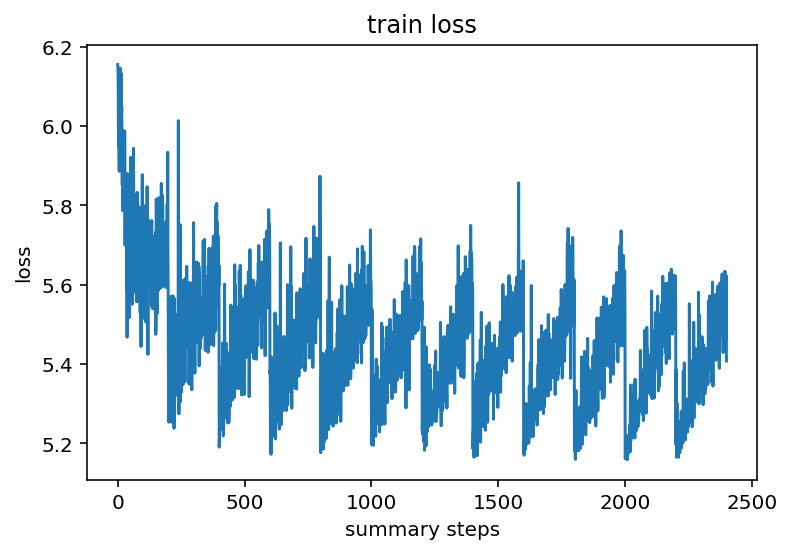

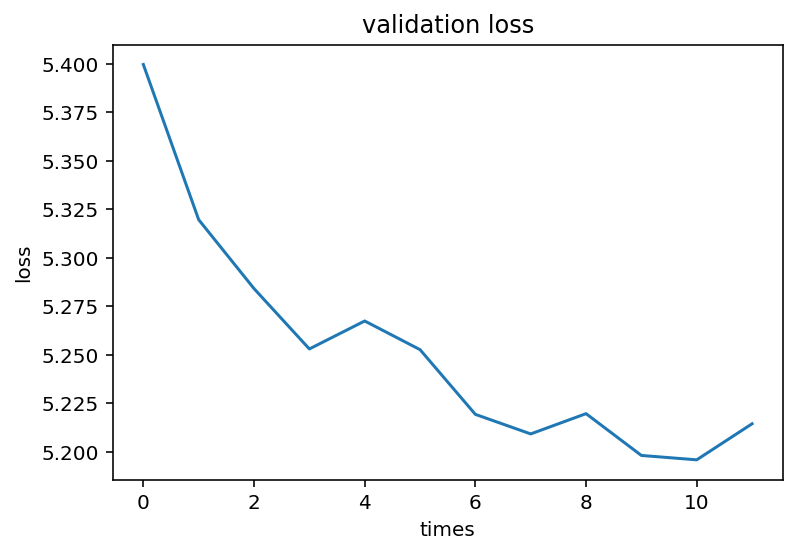

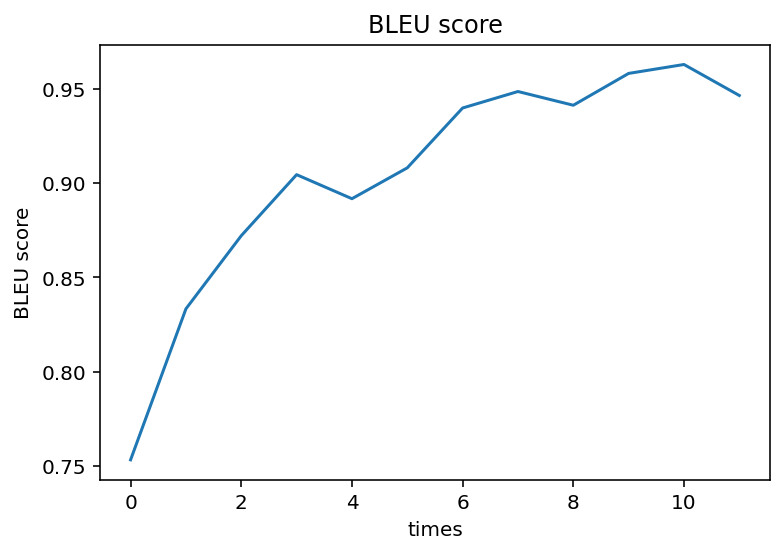

In [34]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses)
plt.xlabel('summary steps')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

plt.figure()
plt.plot(val_losses)
plt.xlabel('times')
plt.ylabel('loss')
plt.title('validation loss')
plt.show()

plt.figure()
plt.plot(bleu_scores)
plt.xlabel('times')
plt.ylabel('BLEU score')
plt.title('BLEU score')
plt.show()

### show embeddings with tSNE

In [35]:
config.load_model = True

data_folder_name = '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_folder'

config.load_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_transformer/model_folder/init_handcrafted/model_"+str(config.num_steps)

test_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
test_loader = data.DataLoader(test_dataset, batch_size=1)
model, optimizer = build_model(config, test_dataset.vocab_size)

rhythm_pattern_list_all.data dataset size: 1019
max index in dict is  470
Transformer(
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (linear_k): Linear(in_features=256, out_features=256, bias=True)
          (linear_v): Linear(in_features=256, out_features=256, bias=True)
          (linear_q): Linear(in_features=256, out_features=256, bias=True)
          (dot_product_attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.5, inplace=False)
            (softmax): Softmax(dim=2)
          )
          (linear_final): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
        (feed_forward): PositionalWiseFeedForward(
          (w1): Conv1d(256, 2048, kernel_size=(1,), stride=(1,))
          (w2): Conv1d(2048, 256, kernel_size=(1,), stride=(1,))
  

torch.Size([472, 256])


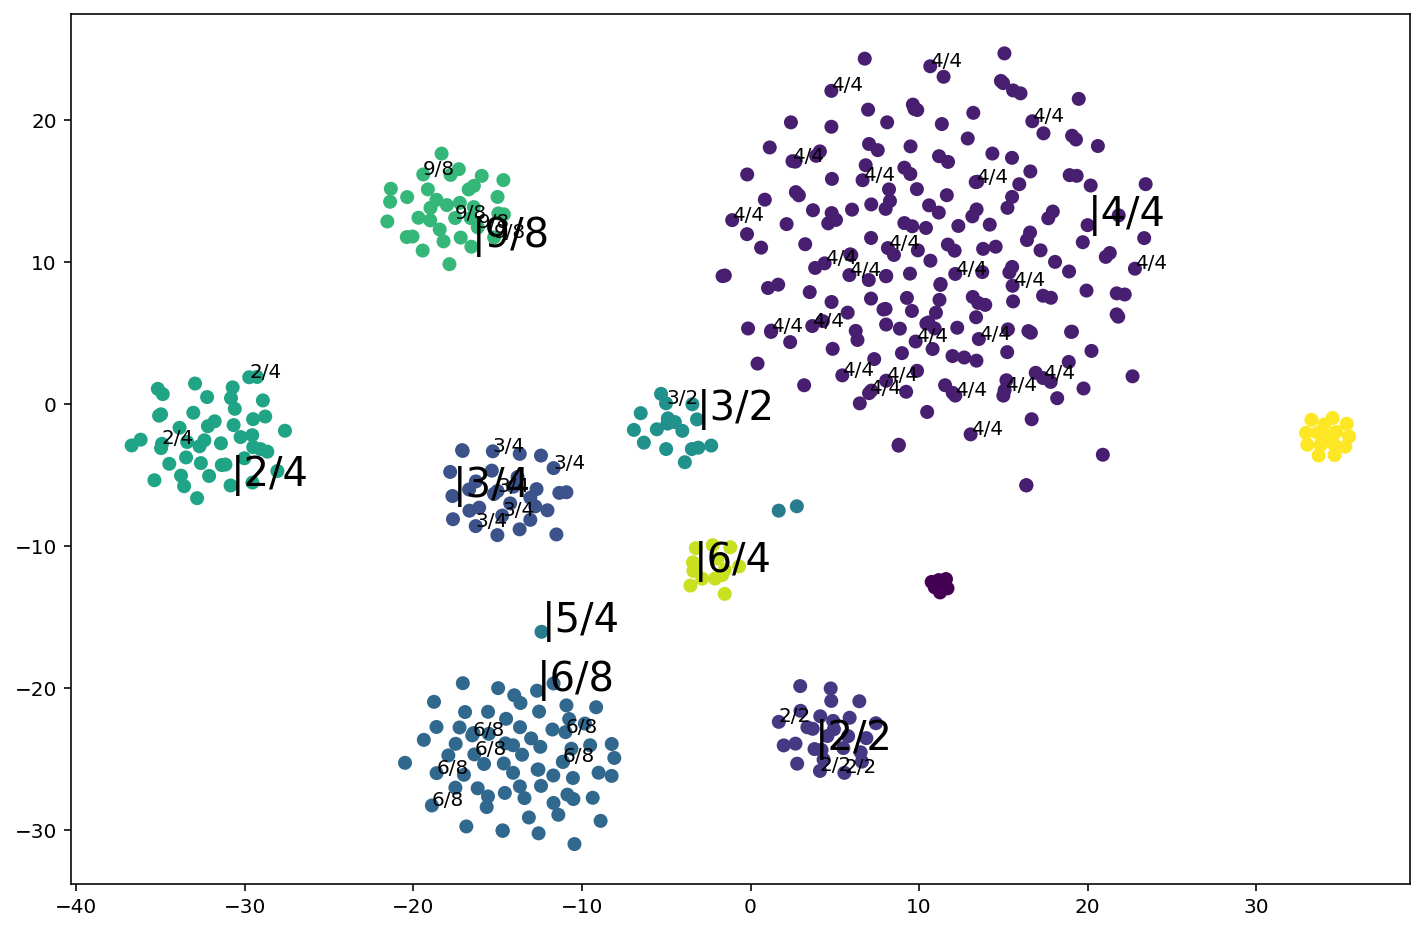

In [36]:
data_folder_name_rhythm_dict = data_folder_name+'/rhythm_dict'
vocab_int2word,vocab_word2int = load_dictionary_as_json(data_folder_name_rhythm_dict)

embedding_list = []
for index in range(test_dataset.vocab_size+1):
    word_idx_tensor = torch.LongTensor([int(index)]).to(device)
    embedding = model.decoder.seq_embedding(word_idx_tensor)
    embedding_list.append(embedding)

temp_embed_tensor = torch.cat(embedding_list, 0)
print(temp_embed_tensor.shape)
embedding_list = temp_embed_tensor.tolist()
embedding_array = np.array(embedding_list)

X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(embedding_array)
fig = plt.figure(figsize=(12, 8)) 
ax = fig.gca()

ax.scatter(X_tsne[:,0],X_tsne[:,1], c=class_array)
for i in range(len(X_tsne)):
    if i>=20: #20=bias for controller tokens in dictionary
        x=X_tsne[i][0]
        y=X_tsne[i][1]
        if i in rhythm_dataset.int2word:
            string_tmp = rhythm_dataset.int2word[i]
            meter_index = string_tmp.find('|')
            if meter_index>0:
                if i%10==0:
                    suffix = string_tmp[meter_index+1:]
                    ax.text(x , y , suffix ,size = 10)
            elif meter_index==0:
                ax.text(x , y , string_tmp ,size = 20)

plt.show()


In [37]:
gensim_posttrain_model = gensim.models.Word2Vec(rhythm_dataset.data, size=emb_dim, window=10, min_count=1, workers=4)
for word in rhythm_dataset.word2int:
    word_id = rhythm_dataset.word2int[word]
    weight_update = embedding_array[word_id]
    gensim_posttrain_model.wv.add(word, weight_update, replace=True)

#### find similar words

In [38]:
gensim_posttrain_model.wv.most_similar('|4/4')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('N0.500,N0.167,N0.083,N0.250,N0.500,N0.500,N0.250,N0.083,N0.167,N0.500,N0.750,N0.250|4/4',
  0.3625376224517822),
 ('N0.500,N0.500,N0.250,N0.250,N0.250,N0.250,N1.000,N1.000|4/4',
  0.3363277018070221),
 ('N0.333,N0.333,N0.333,N0.333,N0.333,N0.333,N1.000,N0.333,N0.333,N0.333|4/4',
  0.33436262607574463),
 ('N0.500,N1.500,N2.000|4/4', 0.31834176182746887),
 ('H0.500,R2.000,R0.500,N0.500,N0.500|4/4', 0.30794042348861694),
 ('R0.500,N0.500,N0.500,N0.500,N1.000,N1.000|4/4', 0.3033703565597534),
 ('N0.500,N0.500,N0.333,N0.333,N0.333,N0.500,N0.500,N1.000|4/4',
  0.2963595986366272),
 ('N0.333,N0.333,N0.333,N0.500,N0.500,N0.333,N0.333,N0.333,N0.500,N0.500|4/4',
  0.2865596413612366),
 ('N0.500,N0.500,N0.500,N2.000,R0.500|4/4', 0.2851981818675995),
 ('R2.500,N0.500,N0.500,N0.500|4/4', 0.2815011739730835)]

In [39]:
gensim_posttrain_model.wv.most_similar('N1.000,N1.000,N1.000,N1.000|4/4')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('N1.000,N0.250,N0.083,N0.167,N0.500,N0.750,N0.250,N0.250,N0.250,N0.250,N0.250|4/4',
  0.329399049282074),
 ('R1.000,N2.000,N1.000|4/4', 0.3278138041496277),
 ('N0.500,N0.500,N0.500,N1.500,R0.500,N0.500|4/4', 0.3190581500530243),
 ('N1.000,N2.000,N1.000|4/4', 0.317221999168396),
 ('N0.500,N0.500,N0.333,N0.333,N0.333,N1.000,N0.500,N0.500|4/4',
  0.3138754367828369),
 ('N0.750,N0.250,N0.500,N0.500,N0.500,N0.500,N1.000|4/4', 0.30893492698669434),
 ('N0.500,N0.500,N0.500,N0.500,N1.000,N0.500,N0.500|4/4', 0.3055344223976135),
 ('N1.000,N0.500,N0.500,N0.333,N0.333,N0.333,N0.333,N0.333,N0.333|4/4',
  0.3041526675224304),
 ('N0.250,N0.250,N0.250,N0.250,N0.500,N0.500,N1.500,N0.500|4/4',
  0.3001933693885803),
 ('N0.250,N0.750,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  0.2974483370780945)]

In [40]:
gensim_posttrain_model.wv.most_similar('|6/8')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('H1.000,R1.500,R0.500|6/8', 0.3401772975921631),
 ('N0.500,N0.250,N0.250,N0.250,N0.250,N0.500,N0.250,N0.250,N0.250,N0.250|6/8',
  0.33141666650772095),
 ('R1.500,N1.500|6/8', 0.29671815037727356),
 ('N0.500,N0.500,N0.500,N1.500|6/8', 0.26018089056015015),
 ('N0.500,N0.500,N0.500,N1.000,N0.250,N0.250|6/8', 0.24211029708385468),
 ('N0.500,N1.000,N0.500,N0.500,N0.500|6/8', 0.2414022535085678),
 ('N1.000,N0.500,N1.500|6/8', 0.24015970528125763),
 ('N0.500,N1.500,N1.000|6/8', 0.23430220782756805),
 ('N0.500,N0.500,N0.500,N0.500,N0.250,N0.250,N0.250,N0.250|6/8',
  0.23224776983261108),
 ('N0.250,N0.750,N0.500,N0.500,N0.500,N0.500|6/8', 0.231159508228302)]

In [41]:
gensim_posttrain_model.wv.most_similar('|5/4')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('N1.000,N1.000,N1.000,N1.000,N1.000|5/4', 0.18110373616218567),
 ('H1.000,R1.500,R0.500|6/8', 0.17179687321186066),
 ('N0.250,N0.750,N1.000,N0.500,N0.500|3/4', 0.1399894654750824),
 ('N1.000,N1.000,N1.000,N0.750,N0.250|2/2', 0.13447904586791992),
 ('N0.750,N0.250,N0.333,N0.333,N0.333,N1.000,N1.000|2/2', 0.1289164274930954),
 ('N1.000,N1.500,R0.500|6/8', 0.11374247074127197),
 ('N0.500,N1.000,N0.500,N1.500,N0.500|4/4', 0.10887899249792099),
 ('N1.000,N0.500,N0.500,N1.500,N0.500|4/4', 0.10302363336086273),
 ('|2/2', 0.10231713205575943),
 ('N2.000,N1.000|3/4', 0.1022123396396637)]

### testing implementation

In [42]:
import copy
config4test = copy.deepcopy(config)
config4test.load_model = True
config4test.mask_prob = 1
test_loss, bleu_score, result_tuplelist = test_process(config4test)
print (f'test loss: {test_loss}, bleu_score: {bleu_score}')

rhythm_pattern_list_all.data dataset size: 1019
max index in dict is  470
Transformer(
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (linear_k): Linear(in_features=256, out_features=256, bias=True)
          (linear_v): Linear(in_features=256, out_features=256, bias=True)
          (linear_q): Linear(in_features=256, out_features=256, bias=True)
          (dot_product_attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.5, inplace=False)
            (softmax): Softmax(dim=2)
          )
          (linear_final): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
        (feed_forward): PositionalWiseFeedForward(
          (w1): Conv1d(256, 2048, kernel_size=(1,), stride=(1,))
          (w2): Conv1d(2048, 256, kernel_size=(1,), stride=(1,))
  

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


test loss: 5.699954440011126, bleu_score: 0.4613199761692912


In [43]:
result_tuplelist[52]

(['<BOS>',
  '|6/8',
  'R2.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N1.000,N0.500|6/8',
  'N0.500,N0.500,N0.500,N1.500|6/8',
  'N1.000,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N1.000,N0.500|6/8',
  'N0.500,N0.500,N0.500,N1.500|6/8',
  'N1.000,N0.500,N0.500,N0.500,N0.500|6/8',
  'N1.500,N1.000,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.

### writing reconstructions to midi

In [45]:
midi_results_path = '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_transformer/midi_results_init_handcrafted'

result_tuplelist_to_midi(result_tuplelist,midi_results_path)


Writing midi file number 0
Writing midi file number 1
Writing midi file number 2
Writing midi file number 3
Writing midi file number 4
Writing midi file number 5
Writing midi file number 6
Writing midi file number 7
Writing midi file number 8
Writing midi file number 9
Writing midi file number 10
Writing midi file number 11
Writing midi file number 12
Writing midi file number 13
Writing midi file number 14
Writing midi file number 15
Writing midi file number 16
Writing midi file number 17
Writing midi file number 18
Writing midi file number 19
Writing midi file number 20
Writing midi file number 21
Writing midi file number 22
Writing midi file number 23
Writing midi file number 24
Writing midi file number 25
Writing midi file number 26
Writing midi file number 27
Writing midi file number 28
Writing midi file number 29
Writing midi file number 30
Writing midi file number 31
Writing midi file number 32
Writing midi file number 33
Writing midi file number 34
Writing midi file number 35
Wr

AssertionError: ignored

## Generate objects

### define generating procedure

In [44]:
def generate(model, ref_seq, masked_seq, masked_len = 10):
    global device
    batch_size=1
    ref_len = ref_seq.shape[1]
    if ref_len<masked_len:
        assert 0, "invalid input length"
    ref_len_tensor = torch.tensor([[ref_len]])

    pred, enc_self_attn, dec_self_attn, ctx_attn = model.generate_greedy(ref_seq,masked_seq,head_len = masked_len)

    return pred, enc_self_attn, dec_self_attn, ctx_attn
    
def generate_process(model, ref_seq, masked_seq, int2word, masked_len = 10):
    pred, enc_self_attn, dec_self_attn, ctx_attn = generate(model, ref_seq, masked_seq, masked_len)
    result = tokens2sentence(pred, int2word)
    ref = tokens2sentence(ref_seq, int2word)
    return result,ref, enc_self_attn, dec_self_attn, ctx_attn

def plot_attention(labels, attention_matrices_list):
    plt.figure(figsize=(8, 8))
    plt.imshow(attention_matrices_list.cpu().detach().numpy())
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.show()

### dataset for generation

In [45]:
config.load_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_transformer/model_folder/init_handcrafted/model_"+str(config.num_steps)

generation_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
generation_dataset.generate_mode = True
generation_loader = data.DataLoader(generation_dataset, batch_size=1)
generation_iter = infinite_iter(generation_loader)
config.load_model = True
model, optimizer = build_model(config, generation_dataset.vocab_size)
logger = 0

rhythm_pattern_list_all.data dataset size: 1019
max index in dict is  470
Transformer(
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (linear_k): Linear(in_features=256, out_features=256, bias=True)
          (linear_v): Linear(in_features=256, out_features=256, bias=True)
          (linear_q): Linear(in_features=256, out_features=256, bias=True)
          (dot_product_attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.5, inplace=False)
            (softmax): Softmax(dim=2)
          )
          (linear_final): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
        (feed_forward): PositionalWiseFeedForward(
          (w1): Conv1d(256, 2048, kernel_size=(1,), stride=(1,))
          (w2): Conv1d(2048, 256, kernel_size=(1,), stride=(1,))
  

In [46]:
mask_index = generation_dataset.word2int['<MASK>']
print(mask_index)

5


### implement generating procedure

Shape of reference is  torch.Size([1, 19])
Shape of masked seq is  torch.Size([1, 19])
------------------Masked seed----------------------
tensor([[ 2, 24, 67, 30, 65, 30, 65, 30, 65, 30,  5,  5,  5,  5,  5,  5,  5,  5,
          5]])
------------------Generation result----------------------
<BOS>
|4/4
R3.000,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N1.000,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N1.000,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N1.000,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.5

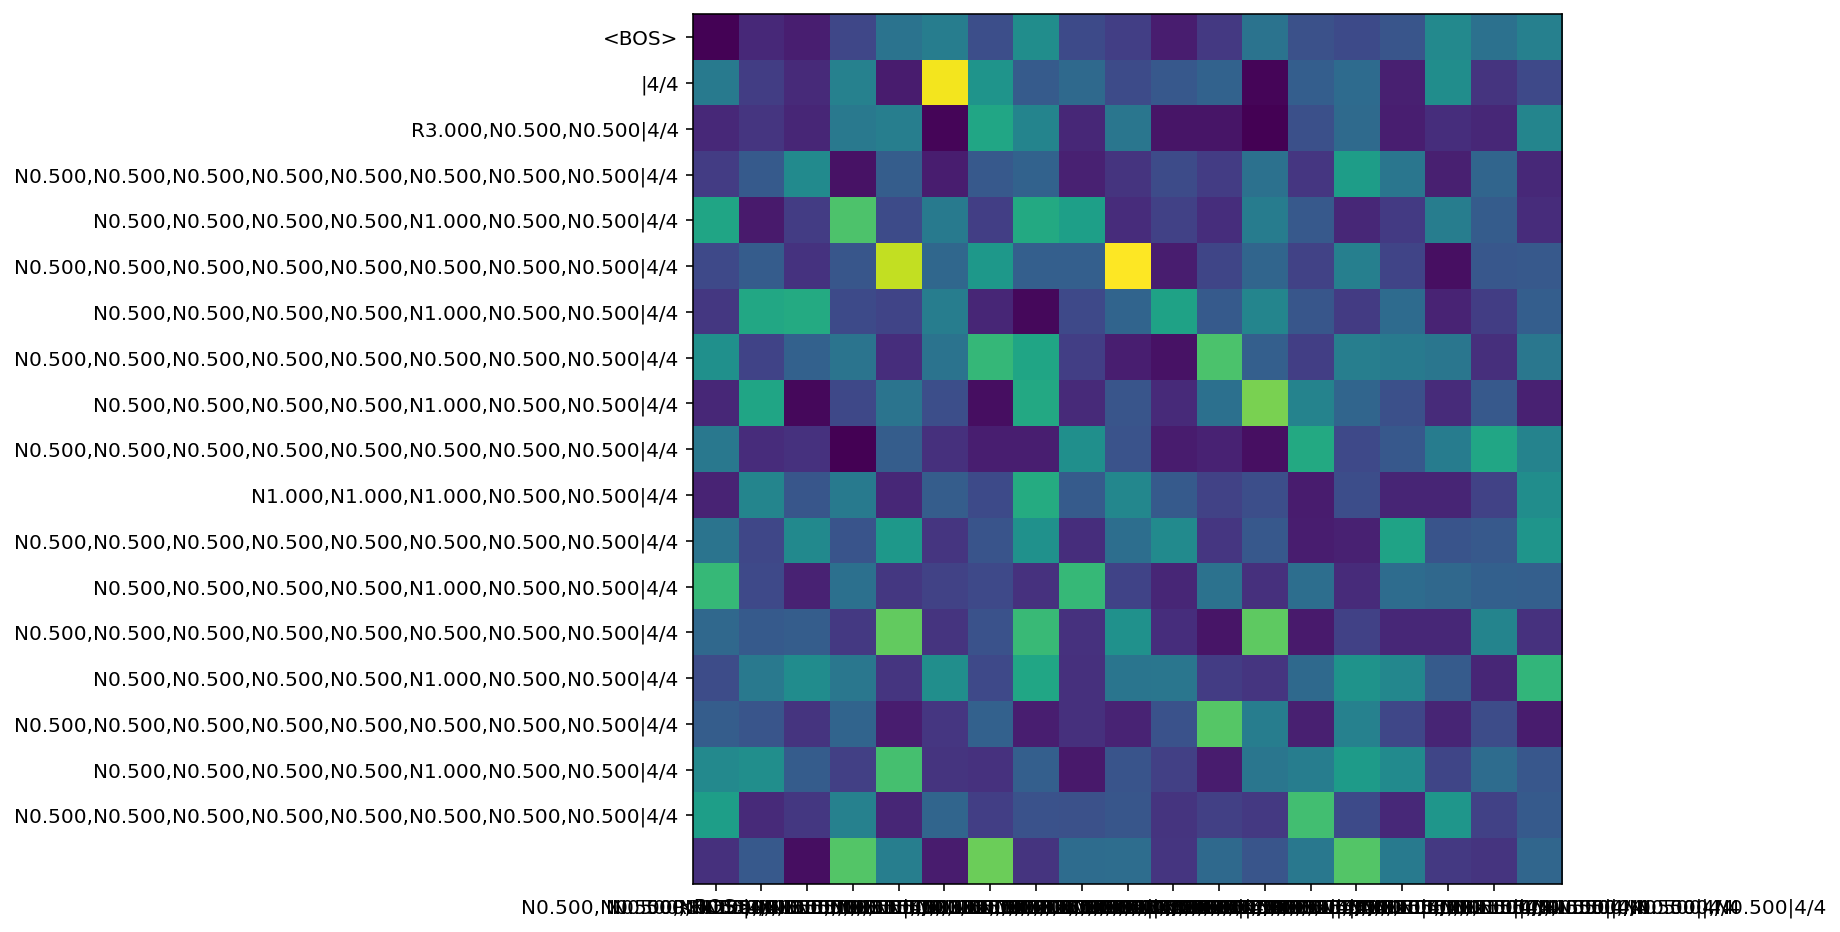

In [71]:
_, ref_seq = next(generation_iter)
#_, seq_to_mask = next(generation_iter)
seq_to_mask = ref_seq.clone()
print('Shape of reference is ',ref_seq.shape)
print('Shape of masked seq is ',seq_to_mask.shape)
ref_seq = ref_seq.to(device)
seq_to_mask = seq_to_mask.to(device)
masked_seq = mask_sequence(ref_seq, seq_to_mask, mask_index, head_len = config.head_len, cut_down = False)
vocab_int2word = generation_dataset.int2word

print('------------------Masked seed----------------------')
print(masked_seq)

result,ref, enc_self_attn, dec_self_attn, ctx_attn = generate_process(model, ref_seq, masked_seq, vocab_int2word, masked_len = config.head_len)
result = result[0]
ref = ref[0]

print('------------------Generation result----------------------')
for ele in result:
    print(ele)
print('------------------Reference seed----------------------')
for ele in ref:
    print(ele)

attn_ave = enc_self_attn[0][0]*0
for lay in range(config.n_layers):
    for h in range(config.num_heads):
        attn_ave += enc_self_attn[lay][h]
attn_ave = attn_ave/(config.n_layers*config.num_heads)
plot_attention(ref, attn_ave)
# write_rhythm_patterns_to_midi([result],midi_results_path=config.store_model_path,file_name='/midi_thythm_generation'+str(logger)+'.mid')
# write_rhythm_patterns_to_midi([ref],midi_results_path=config.store_model_path,file_name='/midi_thythm_seed'+str(logger)+'.mid')
# logger = logger+1